This is for a victim with an action space of [0,1]

In [1]:
AGENT_NAME = r'Models\Victim\SAC_citylearn_challenge_2022_phase_2_Building_6_default_rwd_MARLISA_hyperparams_500.zip'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
SAVE_DIR = r'default SAC 500 results' + '/'
EPS = 0.03
ATK_NAME = f'uACG binary SAC CW 3%'

In [4]:
from stable_baselines3 import SAC

from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedSpaceWrapper, StableBaselines3Wrapper

from art.attacks.evasion import AutoConjugateGradient as ACG
#from KBMproject.mybb import BrendelBethgeAttack as BBA

from art.estimators.classification import PyTorchClassifier as classifier
from art.utils import to_categorical

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt


import KBMproject.utilities as utils

import json
from tqdm import tqdm

%matplotlib inline

In [3]:
def eval_untargeted_attack(agent, env, atk, time_steps:int=None, mask:list=None): #TODO rename function
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack"""
    obs_list = []
    adv_obs_list = []
    a_list = []
    adv_a_list = []
    asr = 0
    mae = 0
    n_features = agent.observation_space.shape[0]
    binary_action_threshold = 0.5

    observations = env.reset()
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(n_features) #1 for all features

    pbar = tqdm(total=time_steps)
    for step in tqdm(range(time_steps)):

        obs_list.append(observations)
        actions = agent.predict(observations, deterministic=True)
        a_list.append(actions[0])
        
        # if(actions[0] < binary_action_threshold):
        #     target = to_categorical([0],2)
        # else:
        #     target = to_categorical([1],2)

        #adv_obs = np.expand_dims(observations, axis=0) #ART atks expect a 2d array
        adv_obs = np.squeeze(
            atk.generate(np.expand_dims(observations, axis=0), 
                               #y=target, 
                               mask=mask)
                               )
        #adv_obs = np.squeeze(adv_obs) #CityLearn envs expect a 1d array
        
        a_adv, _ = agent.predict(adv_obs, deterministic=True)
        a_dist = abs(a_adv[0] - actions[0])[0]
        mae += a_dist
        # if a_adv[0] - actions[0] > 0.5: #check if (dis)charge decision was reversed
        #     asr+=1
        #     adv_obs_list.append(adv_obs)
        # else:
        #     adv_obs_list.append(np.array([np.nan]*n_features)) #same shape as observations

        adv_a_list.append(a_adv[0])
        observations, _, _, _ = env.step(a_adv)

        #update progress bar including asr
        pbar.update(1)
        pbar.set_postfix({'MAE': mae/(step + 1)}, refresh=True)
        if env.done:
            break
    
    pbar.close()
    mae/=time_steps
    return utils.format_kpis(env), np.array(obs_list), np.array(adv_obs_list), np.array(a_list), np.array(adv_a_list), mae 

In [4]:
try: #try to load CityLearn schema
    schema = DataSet.get_schema(DATASET_NAME)
except: #load saved schema otherwise
    with open(DATASET_NAME, 'r') as file:
        schema = json.load(file)

Define RL agent

In [5]:
env = CityLearnEnv(schema, 
                   central_agent=True,
                   buildings=list(schema['buildings'].keys())[0], 
                )
env = NormalizedSpaceWrapper(env)
env = StableBaselines3Wrapper(env)

In [6]:

agent = SAC.load(path=f"{AGENT_NAME}",
                env=env,
                print_system_info=True)
print('Model loaded from storage')


== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.10.12
- Stable-Baselines3: 1.8.0
- PyTorch: 1.12.1
- GPU Enabled: True
- Numpy: 1.23.5
- Gym: 0.21.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.10.12
- Stable-Baselines3: 1.8.0
- PyTorch: 1.12.1
- GPU Enabled: True
- Numpy: 1.23.5
- Gym: 0.21.0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Broda-Milian\anaconda3\envs\CityLearnART\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Model loaded from storage


In [7]:
cols = env.observation_names

In [8]:
observation_masks = np.ones(agent.observation_space.shape)
observation_masks[0:6] = 0 #mask time features

In [9]:
agent.policy.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (latent_pi): Sequential(
    (0): Linear(in_features=31, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=256, out_features=1, bias=True)
  (log_std): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
from copy import deepcopy
policy_net = deepcopy(agent.actor.latent_pi) #copies shared net rather than referencing/changing the agent
policy_net.add_module('4', agent.actor.mu)
policy_net

Sequential(
  (0): Linear(in_features=31, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [11]:
class RegressorParabolicWrapper(nn.Module):
    """wraps a regressor
    and replaces the single output with 2 logits, one is maximized at 0 
    the other at 1 (by default)
    y = a(x-h)^2 + k"""
    def __init__(self, base_model, a1=-1, h1 = -1, k1=0, a2=-1, h2=-1, k2 = 1):
        super(RegressorParabolicWrapper, self).__init__()
        self.base_model = base_model
        self.a1 = a1
        self.a2 = a2
        self.h1 = h1
        self.h2 = h2
        self.k1 = k1
        self.k2 = k2


    def forward(self, x):
        output = self.base_model(x)

        logit0 = self.a1*(torch.pow(output - self.h1,2)) + self.k1
        logit1 = self.a2*(torch.pow(output - self.h2,2)) + self.k2
        
        logits = torch.cat((logit0,logit1), dim=1).float()
        return logits

In [12]:
class RegressorParabolicWrapper(nn.Module):
    """wraps a regressor
    and replaces the single output with 2 logits, one is maximized at 0 
    the other at 1 (by default)
    y = a(x-h)^2 + k"""
    def __init__(self, base_model, r1:float=0.5, h1:float=1.0, k1:float=1.0, r2:float=0.5, h2:float=0.0, k2:float=1.0):
        super(RegressorParabolicWrapper, self).__init__()
        self.base_model = base_model
        self.h1 = h1
        self.h2 = h2
        self.k1 = k1
        self.k2 = k2
        self.a1 = k1/(h1 - r1)**2.0
        self.a2 = k2/(h2 - r2)**2.0


    def forward(self, x):
        output = self.base_model(x)

        logit0 = self.a1*(torch.pow(output - self.h1,2)) + self.k1
        logit1 = self.a2*(torch.pow(output - self.h2,2)) + self.k2
        
        logits = torch.cat((logit0,logit1), dim=1).float()
        return logits

In [13]:
class RegressorLinearWrapper(nn.Module):
    """wraps a regressor
    and replaces the single output with 2 logits, one is maximized at 0 
    the other at 1 (by default)
    y= m*x + b"""
    def __init__(self, base_model, m1=1.0, b1=0.0, m2=-1.0, b2=0.0):
        super(RegressorLinearWrapper, self).__init__()
        self.base_model = base_model
        self.m1 = m1
        self.m2 = m2
        self.b1 = b1
        self.b2 = b2


    def forward(self, input):
        x = self.base_model(input)
        
        logits = torch.cat((self.m1*x + self.b1, self.m2*x + self.b2), dim=1).float()
        return logits

In [2]:
def plot_lines(slopes, intercepts, x_range=(-2, 2)):
    x = np.linspace(x_range[0], x_range[1], 400)
    for slope, intercept in zip(slopes, intercepts):
        y = slope * x + intercept
        plt.plot(x, y)
        plt.grid(True)
        plt.axhline(0, color='black', linewidth=2)
        plt.axvline(0, color='black', linewidth=2)
        plt.axhline(1, color='red', linewidth=0.5)
        plt.axvline(1, color='red', linewidth=0.5)
    plt.show()

def calculate_slope_and_intercept(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

In [37]:
calculate_slope_and_intercept((0,1), (0.5, 0))

(-2.0, 1.0)

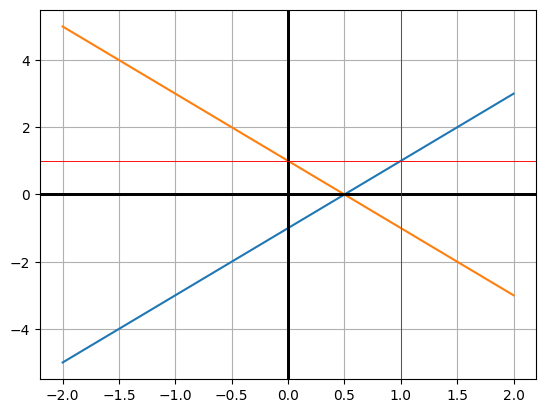

In [5]:
plot_lines([2.0, -2.0], [-1,1])

In [50]:
agent_policy = RegressorLinearWrapper(policy_net, 0.5,1.5,-0.5,1.0)

In [51]:
agent_classifier = classifier(
        model=agent_policy,
        loss=utils.CWLoss(), 
        nb_classes=2,
        input_shape=agent.observation_space.shape,
        device_type='gpu',
        clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
        )

In [52]:
init = 50
iter = int(1000/init)
import logging
logging.basicConfig(level=logging.WARN)
# kwargs = dict(norm=np.inf,
#         targeted=False, #default false
#         overshoot= 1.1,
#         steps=1000,
#         lr=1e-3,
#         lr_decay=0.5,
#         lr_num_decay=20,
#         momentum=0.8,
#         binary_search_steps=10,
#         init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
#         batch_size=1000, 
#         )
kwargs = {"loss_type": None, 
          "eps": EPS, 
          "eps_step": 2*EPS, 
          "batch_size": 1, 
          "nb_random_init": init, 
          "max_iter": iter, 
          "norm": "inf", 
          "verbose": False}
attack = ACG(estimator=agent_classifier, **kwargs,)

In [53]:
%%time
kpis, obs, adv_obs, actions, adv_actions, asr = eval_untargeted_attack(agent, 
                                                                        env, 
                                                                        attack,
                                                                        time_steps=100,
                                                                        mask=observation_masks)

100%|██████████| 100/100 [03:12<00:00,  1.92s/it, MAE=[0.1306902]]


CPU times: total: 3min 12s
Wall time: 3min 12s


mean action distance for linear wrapper with eps = 0.03, 10 steps, (m1, b1, m2, b2)
- (1, 0, -1, 0): 0.068
- (1, 0, -1, 1): 0.056
- (1,0,-0.5,1): 0.024
- (0.5,1.5,-0.5,1): 0.187, 0.204, 0.211
- (0.5,0.5,-0.5,1): 0.094
- (0.5, 2.0, -0.5, 1.0): 0.2, 0.16
- (0.5, 1.0, -0.5, 1.0): 0.075
- (0.5, 0, -0.5, 1): 0.024
- (2, -1, 0.5, 1): 0.066

for 100 steps:
- (0.5,1.5,-0.5,1): 0.15, 0.134, 0.131
- (2, -1, 0.5, 1): 0.131
- (1.0, 0.0, -1.0, 0.0): 0.129
- (0.5,0.5,-0.5,0.5): 0.119
- (2.0,-2.0,-1.0,1.0): 0.069 (nice!)
- (2.0,-2.0,0.0,2.0): 0.045 #system above translated up

mean action distance for parabolic wrapper with eps = 0.03, 10 steps (r,h,k)
- (0.5,1,1), (0.5,1,0): 0.087
- (-1,1,1), (2,1,0): 0.0425
- (0.25,1,1), (0.75,1,0): 0.0834

In [ ]:
display(kpis)

In [16]:
with open(SAVE_DIR+f'{ATK_NAME} parameters.json', 'w') as f:
    json.dump(kwargs, f)

In [17]:
kpi = kpis

In [18]:
kpi_savename = SAVE_DIR+'KPIs.csv'
try:
    df_kpis = pd.read_csv(kpi_savename, index_col=0)
    df_kpis[ATK_NAME] = kpi.values
    df_kpis.to_csv(kpi_savename)
    print(f'{kpi_savename} updated')
except:
    kpi.name = ATK_NAME
    kpi.to_csv(kpi_savename)
    print(f'{kpi_savename} created')

default SAC 500 results/KPIs.csv updated


In [19]:
df_obs = pd.DataFrame(obs)
df_obs.columns = cols
df_obs['a'] = actions
df_obs.to_csv(SAVE_DIR+ATK_NAME+' a-obs.csv')

In [20]:
df_obs = pd.DataFrame(adv_obs)
df_obs.columns = cols
df_obs['a'] = adv_actions
df_obs.to_csv(SAVE_DIR+ATK_NAME+' adv a-obs.csv')

In [21]:
asr_savename = SAVE_DIR+'ASRs.csv'
try:
    df_asrs = pd.read_csv(asr_savename)
    df_asrs[ATK_NAME] = asr
    df_asrs.to_csv(asr_savename)
    print(f'{asr_savename} updated')
except:
    asr = pd.Series([asr])
    asr.name = ATK_NAME
    asr.to_csv(asr_savename)
    print(f'{asr_savename} created')

default SAC 500 results/ASRs.csv updated
